In [13]:
import torch
import os
import pandas as pd
import numpy as np
from utils.config import config_dataset
from utils.helper import ObjectView
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.utils_gan_wasserstein import Discriminator_wassertein, Generator_linear, plot_GAN_loss, fit_gan_wasserstein, build_gan_scenarios

# Set the torch seed for result reproducibility
torch_seed = 3307
torch.manual_seed(torch_seed)

In [14]:
indices = []
non_null_indexes = list(np.delete(np.asarray([i for i in range(96)]), indices))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/X_train.pt")
X_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/X_test.pt")
cond_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/cond_train.pt")
cond_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/cond_test.pt")
PV_base_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/PV_base_train.pt")
PV_base_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/PV_base_test.pt")

print(X_train.shape)
print(X_test.shape)
print(cond_train.shape)
print(cond_test.shape)
print(PV_base_train.shape)
print(PV_base_test.shape)

X_train = X_train + 1
X_test = X_test + 1
X_train, X_val, cond_train, cond_val = train_test_split(X_train, cond_train, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, cond_train.shape, cond_test.shape, X_val.shape, cond_val.shape

y_LS_scaler = StandardScaler()
y_LS_scaler.fit(X_train)
y_LS_scaled = y_LS_scaler.transform(X_train)
y_VS_scaled = y_LS_scaler.transform(X_val)
y_TEST_scaled = y_LS_scaler.transform(X_test)

x_LS_scaler = StandardScaler()
x_LS_scaler.fit(cond_train)
x_LS_scaled = x_LS_scaler.transform(cond_train)
x_VS_scaled = x_LS_scaler.transform(cond_val)
x_TEST_scaled = x_LS_scaler.transform(cond_test)

torch.Size([8760, 96])
torch.Size([2190, 96])
torch.Size([8760, 79])
torch.Size([2190, 79])
torch.Size([8760, 7, 96])
torch.Size([2190, 7, 96])


In [15]:
# --------------------------------------------------------------------------------------------------
# Set the model
# --------------------------------------------------------------------------------------------------
# n_s = 100 # num of samples
n_s = 20
N_q = 96
# semble un bon set de hp mais d'un calcul a l'autre les résultats changent bcp ...
nb_epoch = 200
cf_GAN_wasserstein = {
    'name': 'WGANGP_1',
    'cond_in': x_LS_scaled.shape[1],
    'in_size': y_LS_scaled.shape[1],
    'latent_s': 512,
    'gen_w': 256 * 4,
    'gen_l': 2,
    'n_discriminator': 5,
    'lambda_gp': 10,
    'betas': (0.0, 0.9),
    'weight_decay': 1 * 10 ** (-4),
    'learning_rate': 2 * 10 ** (-4),
}

print('WGAN-GP latent_s %s gen_w %s gen_l %s weight_decay %.4e lr %.4e lambda_gp %s' % (cf_GAN_wasserstein['latent_s'], cf_GAN_wasserstein['gen_w'], cf_GAN_wasserstein['gen_l'], cf_GAN_wasserstein['weight_decay'], cf_GAN_wasserstein['learning_rate'], cf_GAN_wasserstein['lambda_gp']))


WGAN-GP latent_s 512 gen_w 1024 gen_l 2 weight_decay 1.0000e-04 lr 2.0000e-04 lambda_gp 10


In [16]:
config = cf_GAN_wasserstein

config['Adam_args'] = {"betas":config['betas'], "lr": config['learning_rate'], "weight_decay": config['weight_decay']}

# Instance critic neural network: discriminator using Wasserstein distance estimate
dis = Discriminator_wassertein(latent_s=config['latent_s'], cond_in=config['cond_in'], in_size=config['in_size'], gen_w=config['gen_w'], gen_l=config['gen_l'], lambda_gp=config['lambda_gp'], gpu=True)
dis.weights_initialize(mean=0.0, std=0.02)
dis.train()
# Instance generator neural network
gen = Generator_linear(latent_s=config['latent_s'], cond_in=config['cond_in'], in_size=config['in_size'], gen_w=config['gen_w'], gen_l=config['gen_l'], gpu=True)
gen.weights_initialize(mean=0.0, std=0.02)
gen.train()

# Instance optimizers
opt_D = torch.optim.Adam(dis.parameters(), lr=config['learning_rate'], betas=config['betas'], weight_decay=config['weight_decay'])
opt_G = torch.optim.Adam(gen.parameters(), lr=config['learning_rate'], betas=config['betas'], weight_decay=config['weight_decay'])

# -----------------------------------------------------------------------------------------------
# Fit the GAN
# -----------------------------------------------------------------------------------------------
# print('Fit GAN with %s epochs' % (nb_epoch))
training_time = 0.
loss, gen, dis = fit_gan_wasserstein(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                                y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled, gen=gen, dis=dis, opt_gen=opt_G, opt_dis=opt_D, n_discriminator=config['n_discriminator'], gpu=True)

print('Training time %.2f s' % (training_time))
epoch_min_D = np.nanargmin(loss[:, 2])
epoch_min_G = np.nanargmin(loss[:, 3])
print('epoch %s loss D VS is min = %.2f epoch %s loss G VS is min = %.2f' % (epoch_min_D, loss[epoch_min_D, 2], epoch_min_G, loss[epoch_min_G, 3]))

Fitting time_tot 2 mintime left : 0.078891 min - D LS loss: -2.402756 G LS loss: -5.068255 D VS loss: -1.689011 G VS loss: -6.162621
Training time 0.00 s
epoch 10 loss D VS is min = -8.09 epoch 44 loss G VS is min = -8.06


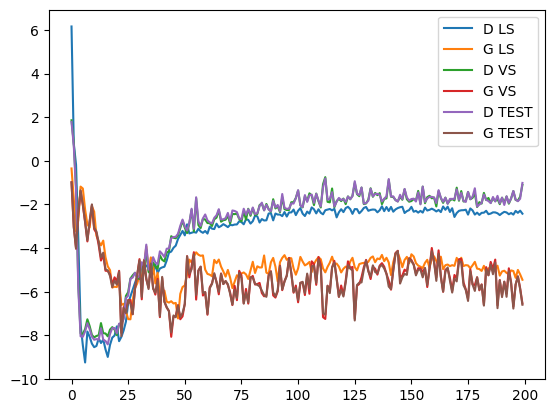

In [17]:
plt.figure()
plt.plot(loss[:, 0], label='D LS')
plt.plot(loss[:, 1], label='G LS')
plt.plot(loss[:, 2], label='D VS')
plt.plot(loss[:, 3], label='G VS')
plt.plot(loss[:, 4], label='D TEST')
plt.plot(loss[:, 5], label='G TEST')
plt.legend()

In [18]:
max_cap = 20
tag = "load"
# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)
generation_time = 0.
# s_LS = build_gan_scenarios(n_s=n_s, x=x_LS_scaled, y_scaler=y_LS_scaler, gen=gen, max=max_cap, gpu=gpu, tag=tag, non_null_indexes=non_null_indexes)
s_TEST = build_gan_scenarios(n_s=n_s, x=x_TEST_scaled, y_scaler=y_LS_scaler, gen=gen, max=max_cap, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
s_train = build_gan_scenarios(n_s=n_s, x=x_LS_scaled, y_scaler=y_LS_scaler, gen=gen, max=max_cap, gpu=True, tag=tag, non_null_indexes=non_null_indexes)

Scenario generation time_tot 0.0 min00000 min


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Scenario generation time_tot 0.1 min00000 min


In [19]:
X_test_hat = s_TEST.reshape(-1, 96, s_TEST.shape[-1])
X_test_hat = torch.tensor(X_test_hat).permute(0, 2, 1)

In [20]:
X_train_hat = s_train.reshape(-1, 96, s_train.shape[-1])
X_train_hat = torch.tensor(X_train_hat).permute(0, 2, 1)

In [21]:
X_test_hat.shape, X_train_hat.shape

(torch.Size([2190, 20, 96]), torch.Size([7884, 20, 96]))

In [22]:
num_class = config_dataset["num_class"]

def denorm(x):
    loads = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/loads_raw.pt")
    lmin = []
    lmax = []
    for i in range(loads.shape[0]):
        load = loads[i]
        lmin.append(load.min())
        lmax.append(load.max())
    lmin = torch.stack(lmin)[:num_class]
    lmax = torch.stack(lmax)[:num_class]
    lmin = lmin.unsqueeze(1).repeat(1, int(x.shape[0]/num_class))
    lmax = lmax.unsqueeze(1).repeat(1, int(x.shape[0]/num_class))
    lmin = lmin.reshape((-1, 1, 1))
    lmax = lmax.reshape((-1, 1, 1))
    return (x + 1) * (lmax - lmin) / 2 + lmin

In [23]:
torch.save(denorm(X_test_hat - 1), "../result/data/pecan/load_hat_gan.pt")

In [25]:
X_test_hat.shape

torch.Size([2190, 20, 96])

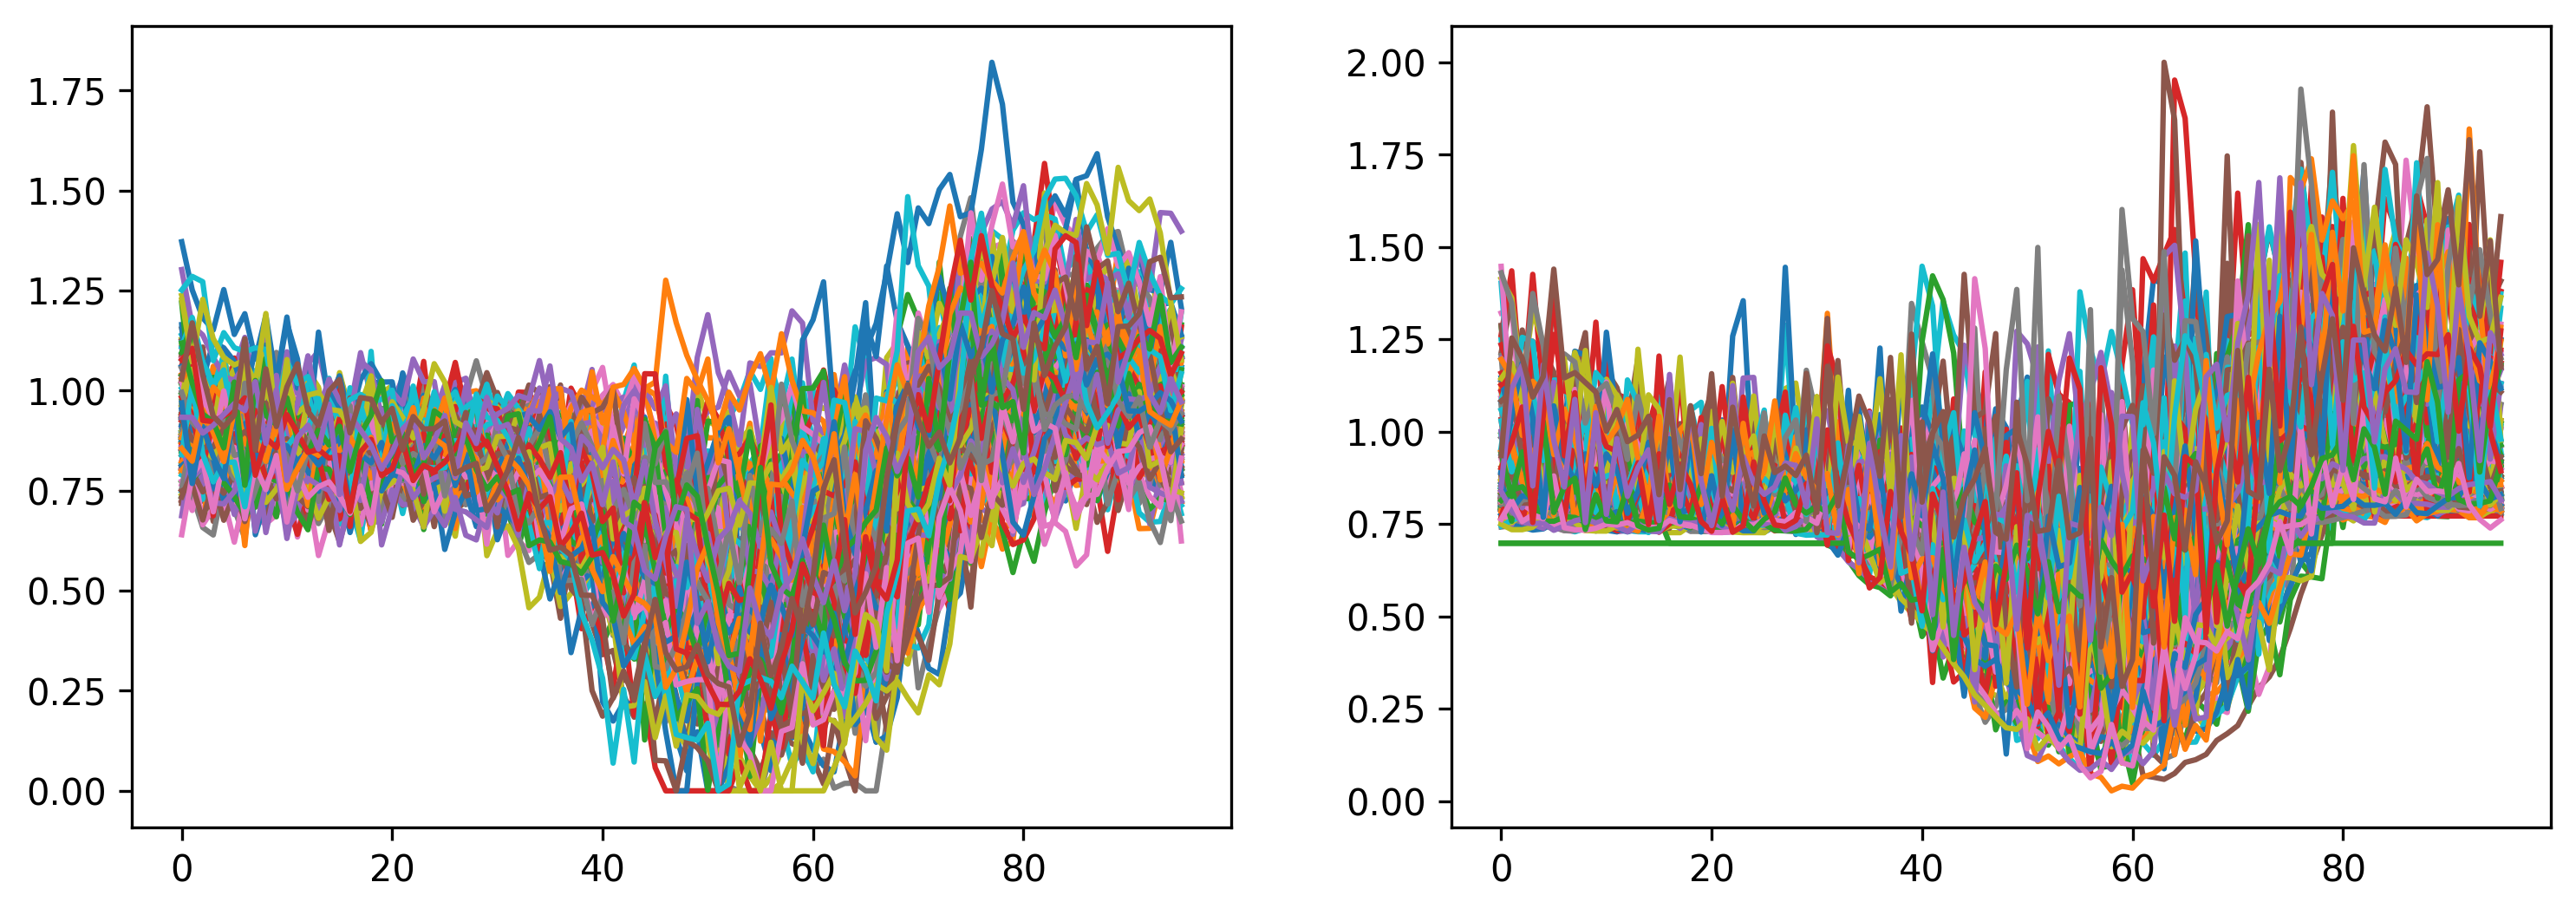

In [26]:
user = 0
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(1,2,1)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test_hat[i, 0, :])
plt.subplot(1,2,2)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test[i])

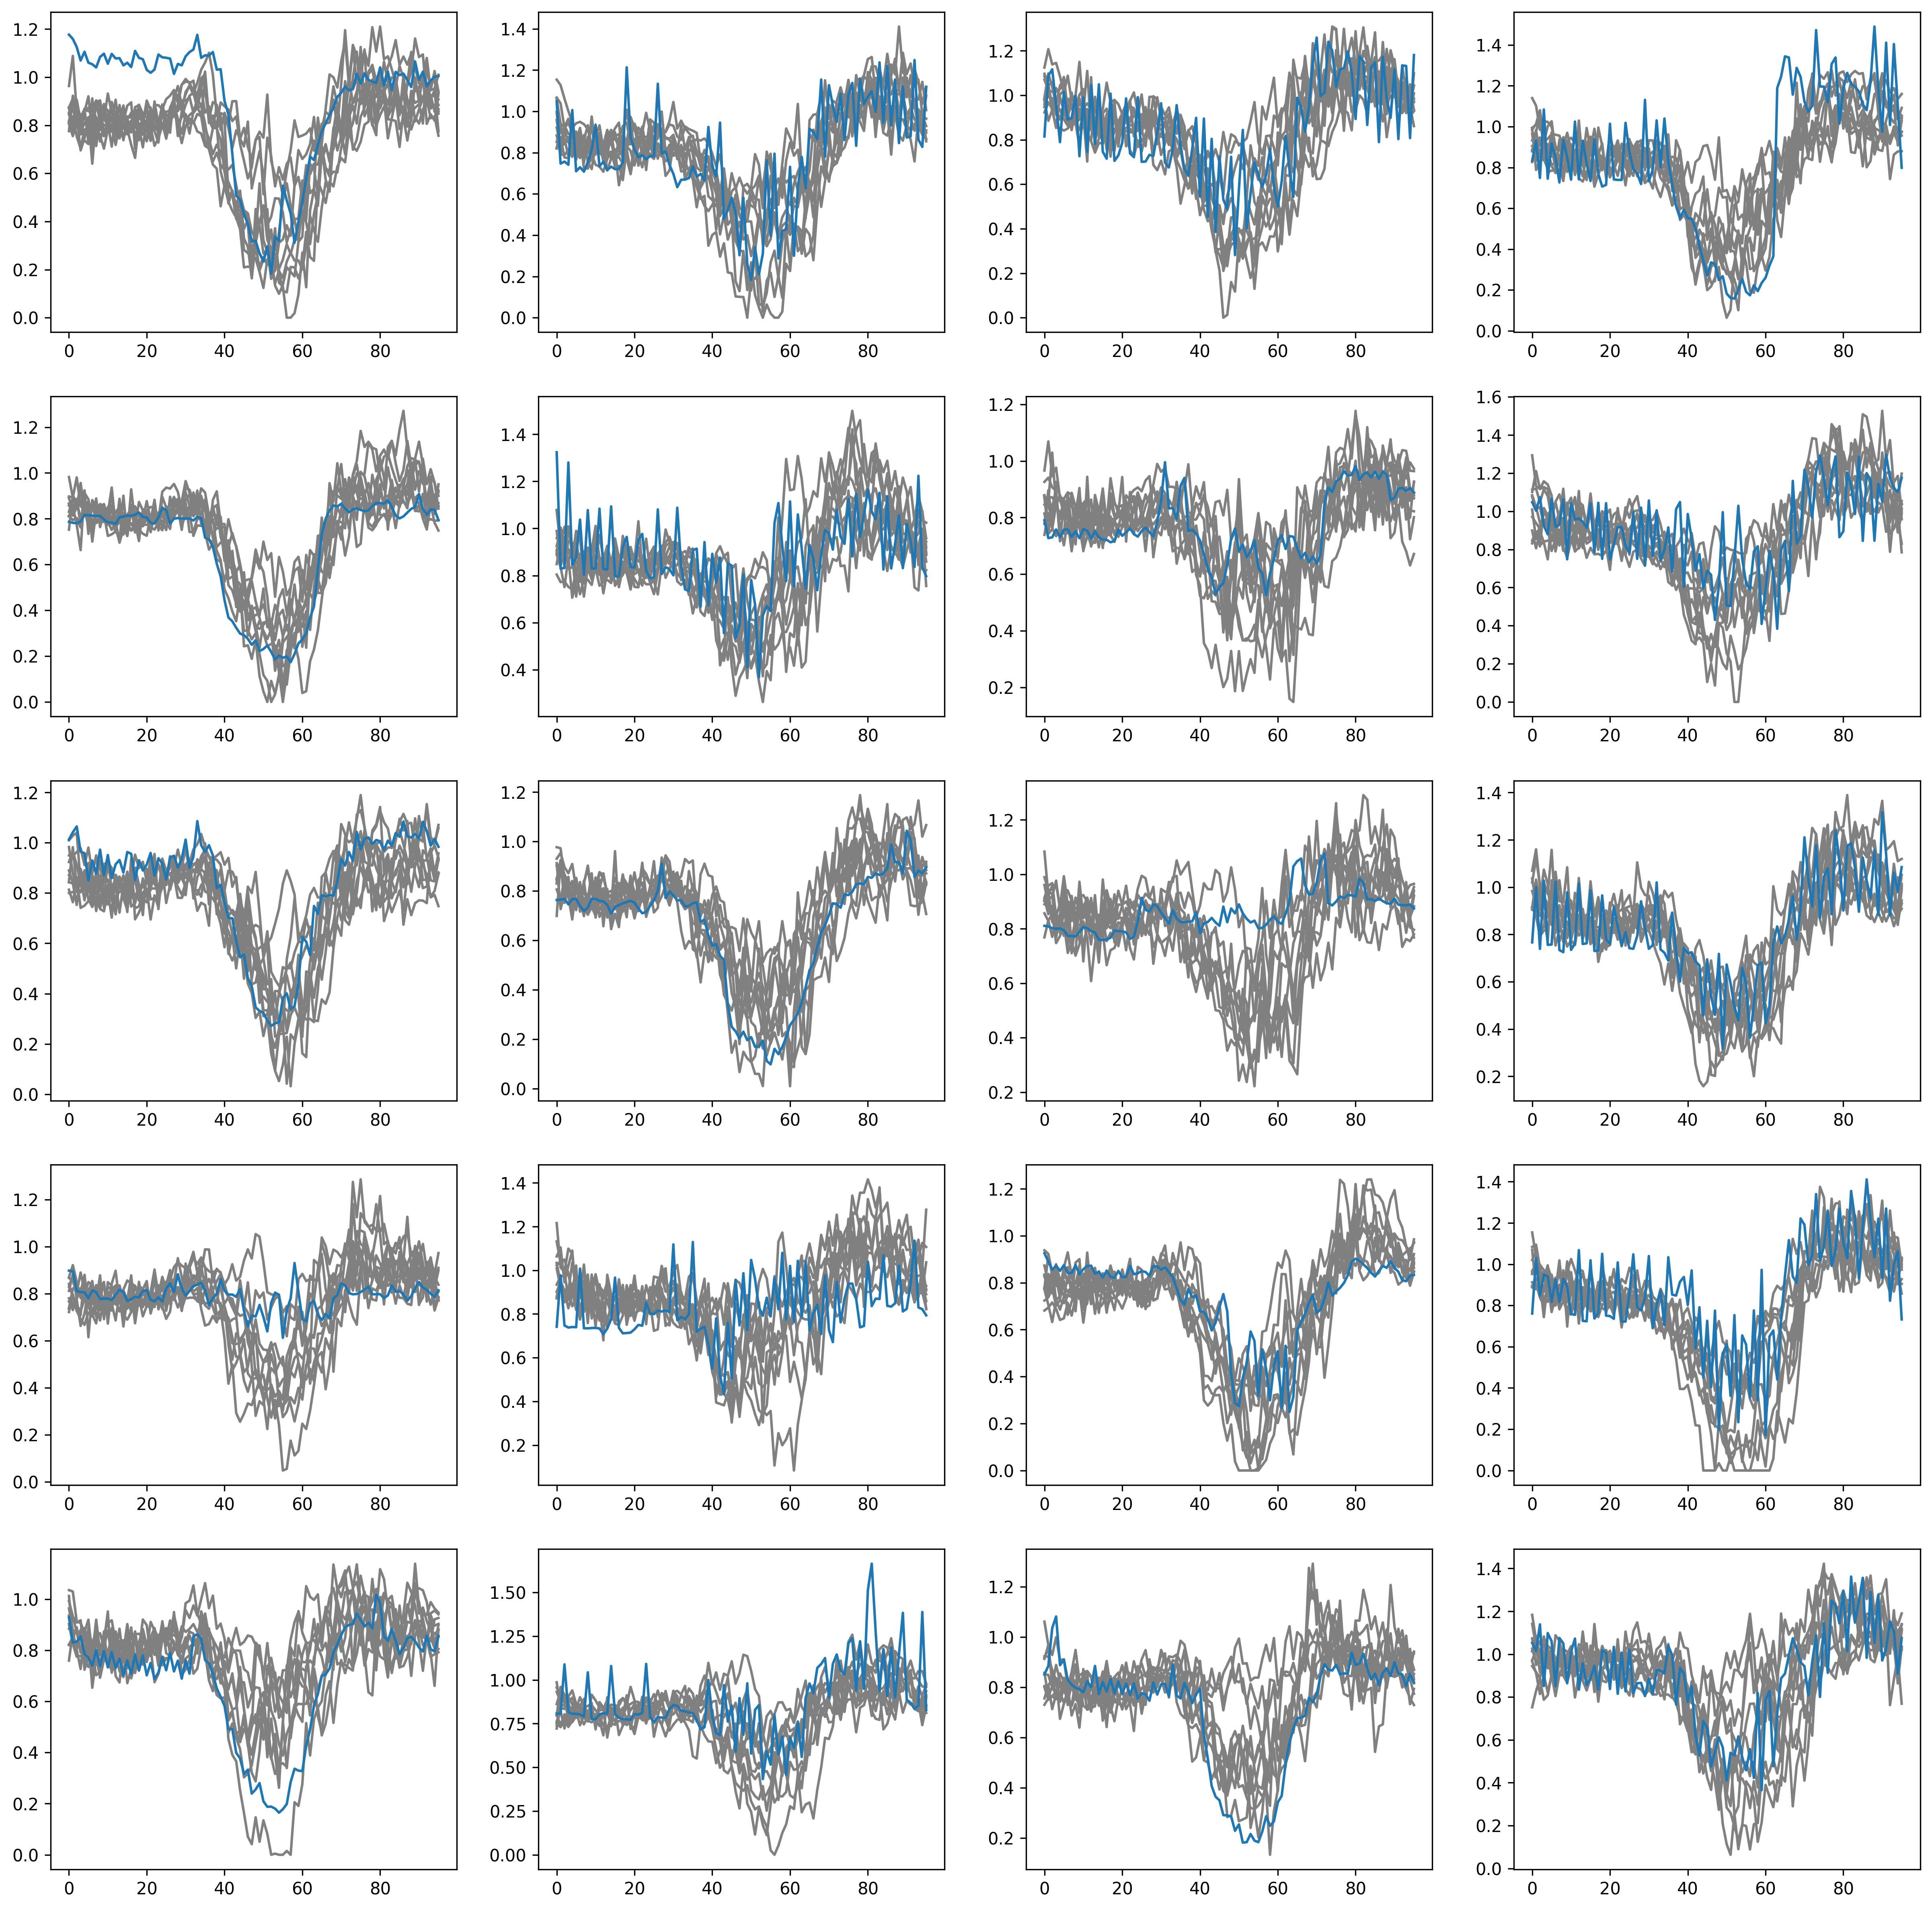

In [27]:
n = 20
plt.figure(figsize=(20,20), dpi=300)
for j in range(n):
    plt.subplot(int(n/4), 4, j+1)
    j = j + 200
    for i in range(10):
        plt.plot(X_test_hat[j][i], color='gray')
    plt.plot(X_test[j])